In [3]:
import numpy as np
import matplotlib.pyplot as plt
from read_lapd import read_lapd_data
# from toolbox import bdot
from bdot_calib import bint_fft
import numpy as np
from scipy import constants as const
from scipy import fft
import time
from scipy.ndimage import maximum_filter1d, uniform_filter1d

Reading data from motion list XY[2]: Ta_paddle
Reading motion list from module:  6K Compumotor
No 3302 boards used.
SIS 3305 boards used = [1, 2]
SIS 3305 effective clock rate: Board 1 = 5000.0 MHz
SIS 3305 effective clock rate: Board 2 = 5000.0 MHz
---------- SIS 3305 list of enabled channels (4) ----------
[ 0] Board 1, Channel 1: Bx-P25mov
[ 1] Board 1, Channel 5: By-P25mov
[ 2] Board 2, Channel 1: Bz-P25mov
[ 3] Board 2, Channel 5: By-P26fxd
------------------------------------------------------------
Reading SIS 3305...
------------------------------------------------------------
Data geometry = xy-plane
Read Channels = 1
Shot range    = 4 to 4
X value range = 20 to 20
Y value range = 0 to 0
 (xx/yy/zz/shots/steps/chan) = (1/1/1/1/1/1) of (1/1/1/1/1/1)
1 5
Reading config name /Raw data + config/SIS crate/siscf0-4ch-5GHz-1Mpnts-200us [Slot 13: SIS 3305 FPGA 2 ch 1]
!!! (nt, nx, ny, nshots, nchan) = (1007616, 1, 1, 1, 1)
{'Calibration tag': b'07/20/2020', 'Profile z locations': arra

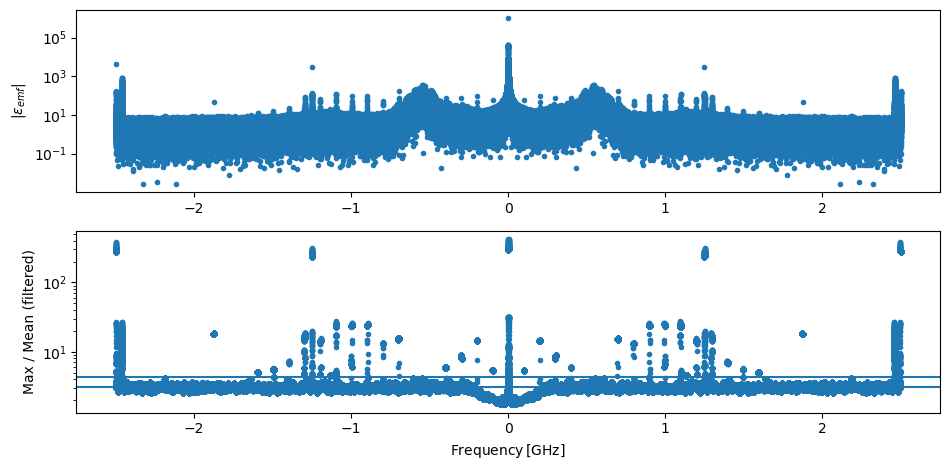

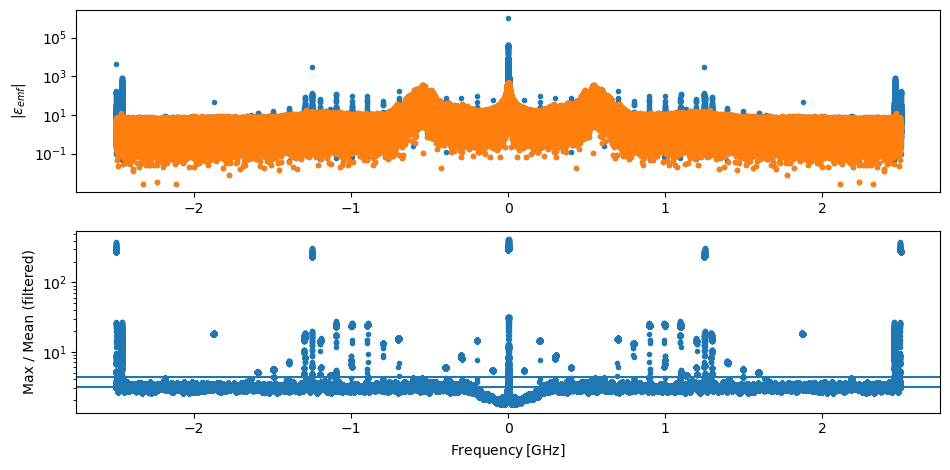

In [23]:
datapath = '/data/BAPSF_Data/Energetic_Electron_Ring/jul2021/'
filename = datapath + \
        '04-bfield-p25-plane-He-1kG-uwave-l5ms-mirror-min-305G.hdf5'


# filename = datapath + \
#         '24-bfield-p25-xline-uwave-off-mirror-min-305G.hdf5'
#24-bfield-p25-xline-uwave-off-mirror-min-305G.hdf5
savepath = './'
# read data of one channel in one shot and one location
data = read_lapd_data(filename, rchan=[1], rshot=[4], xrange=[20], yrange=[0]) 

# fft
n0 = data['data'].shape[0]
nfast = 2**(int(np.log2(n0-1))+1)
emf_fft = fft.fft(data['data'], n=nfast, axis=0)
emf_fft = np.squeeze(emf_fft)

emf_max = maximum_filter1d(np.abs(emf_fft), size=1000, mode='wrap')
emf_mean = uniform_filter1d(np.abs(emf_fft), size=1000, mode='wrap')
emf_ratio_median = np.median(emf_max / emf_mean)
emf_ratio_mean = np.mean(emf_max / emf_mean)
print('median(emf_max / emf_mean) = {}'.format(emf_ratio_median))
print('mean(emf_max / emf_mean) = {}'.format(emf_ratio_mean))

# plt.style.use('dark_background')

fig, axs = plt.subplots(2, 1, figsize=[9.6,4.8])

freq = fft.fftfreq(nfast, d=data['dt'][0])

ax = axs[0]
ax.semilogy(freq/1e9, np.abs(emf_fft), '.')
ax.set_ylabel(r'$\vert \varepsilon_{emf} \vert$')

ax = axs[1]
ax.semilogy(freq/1e9, emf_max/emf_mean, '.')
ax.axhline(y=emf_ratio_median)
ax.axhline(y=emf_ratio_mean)
ax.set_xlabel(r'$\mathrm{Frequency}\,[\mathrm{GHz}]$')
ax.set_ylabel('Max / Mean (filtered)')

plt.tight_layout()
plt.savefig(savepath+'tst_rmradio.png')
# plt.close()



def calcRegionBounds(bool_array):
    '''
    Returns the lower and upper bounds of contiguous regions.

    Parameters
    ==========
    bool_array    1-D Binary numpy array
    '''
    assert(bool_array.dtype=='bool')
    idx = np.diff(np.r_[0, bool_array, 0]).nonzero()[0]
    assert(len(idx)%2 == 0)
    return np.reshape(idx, (-1,2))

# index of short pulses
idx = (emf_max / emf_mean) > 4
# calculate bounds of short pulses
ibd = calcRegionBounds(idx)


emf_copy = emf_fft.copy()
for i in range(ibd.shape[0]):
    aux_arr = np.arange(ibd[i,0], ibd[i,1])
    # The first and last chunks are contiguous
    if i == 0 and ibd[0,0] == 0 and ibd[-1,1] == len(emf_fft):
        lwgt = (ibd[0,1] - aux_arr) \
                / (ibd[0,1] + ibd[-1,1] - ibd[-1,0] + 1)
        rwgt = (aux_arr + ibd[-1,1] - ibd[-1,0] + 1) \
                / (ibd[0,1] + ibd[-1,1] - ibd[-1,0] + 1)
        lval = emf_fft[ibd[-1,0]-1]
        rval = emf_fft[ibd[0,1]]
    elif i == ibd.shape[0]-1 and ibd[-1,1] == len(emf_fft) and ibd[0,0] == 0:
        lwgt = (ibd[-1,1] - aux_arr + ibd[0,1]) \
                / (ibd[-1,1] - ibd[-1,0] + ibd[0,1] +1)
        rwgt = (aux_arr - ibd[-1,0] + 1) \
                / (ibd[-1,1] - ibd[-1,0] + ibd[0,1] +1)
        lval = emf_fft[ibd[-1,0]-1]
        rval = emf_fft[ibd[0,1]]
    # Contiguous sections in between
    else:
        lwgt = (ibd[i,1] - aux_arr) / (ibd[i,1] - ibd[i,0] + 1)
        rwgt = (aux_arr - ibd[i,0] + 1) / (ibd[i,1] - ibd[i,0] + 1)
        lval = emf_fft[ibd[i,0]-1]
        rval = emf_fft[ibd[i,1]%len(emf_fft)]
    emf_copy[ibd[i,0]:ibd[i,1]] = lwgt*lval + rwgt*rval



fig, axs = plt.subplots(2, 1, figsize=[9.6,4.8])

freq = fft.fftfreq(nfast, d=data['dt'][0])

ax = axs[0]
ax.semilogy(freq/1e9, np.abs(emf_fft), '.')
ax.semilogy(freq/1e9, np.abs(emf_copy), '.')
ax.set_ylabel(r'$\vert \varepsilon_{emf} \vert$')

ax = axs[1]
ax.semilogy(freq/1e9, emf_max/emf_mean, '.')
ax.axhline(y=emf_ratio_median)
ax.axhline(y=emf_ratio_mean)
ax.set_xlabel(r'$\mathrm{Frequency}\,[\mathrm{GHz}]$')
ax.set_ylabel('Max / Mean (filtered)')

plt.tight_layout()

(0.0, 1.0)

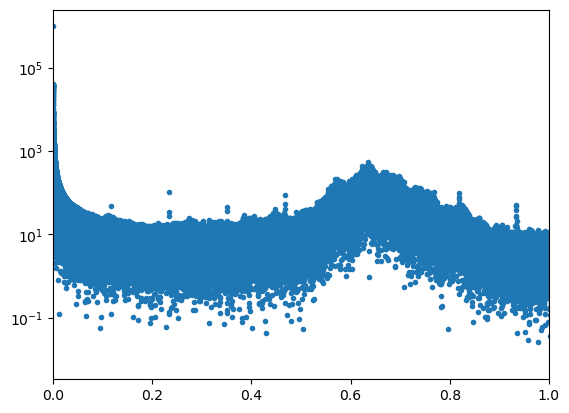

In [11]:
plt.semilogy(freq/1e9/0.8538, np.abs(emf_fft), '.')
plt.xlim(0,1)

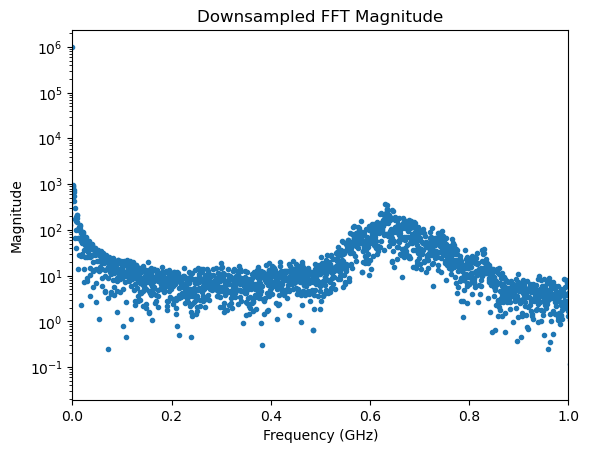

In [15]:
downsampled_freq = freq[::100]
downsampled_emf_fft = emf_fft[::100]

# Plot the downsampled data
plt.semilogy(downsampled_freq/1e9/0.8538, np.abs(downsampled_emf_fft), '.')

# Set the x-axis limit
plt.xlim(0, 1)

# Add labels and title for clarity (optional)
plt.xlabel('Frequency (GHz)')
plt.ylabel('Magnitude')
plt.title('Downsampled FFT Magnitude')

# Show the plot
plt.show()

Text(0.5, 1.0, 'Microwave on')

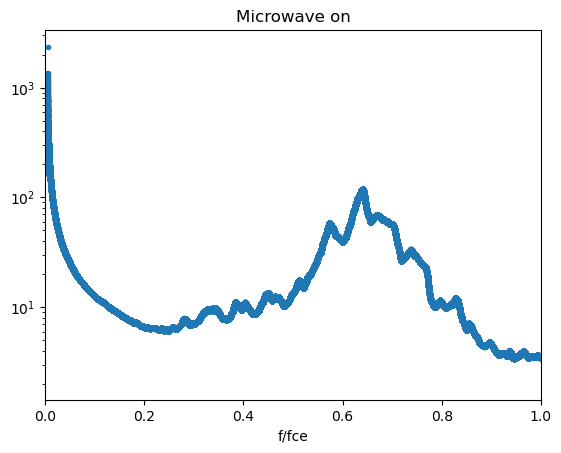

In [25]:
window_size = 1000  # Adjust based on your smoothing requirements

# Define a simple moving average function
def moving_average(data, size):
    return np.convolve(data, np.ones(size), 'valid') / size

# Apply the moving average filter
smoothed_emf_fft = moving_average(np.abs(emf_fft), window_size)

# Since the moving average reduces the array size, adjust the frequency array
# We take the center point of each window for the frequency
adjusted_freq = freq[window_size-1:]  # Adjusting freq array size to match smoothed signal

# For plotting, you might still want to decimate or just plot the smoothed data
# Here, we just plot the smoothed data
plt.semilogy(adjusted_freq/1e9/0.8538, smoothed_emf_fft, '.')

# Set the x-axis limit
plt.xlim(0, 1)

# Add labels and title for clarity (optional)
plt.xlabel('f/fce')
plt.title('Microwave on')

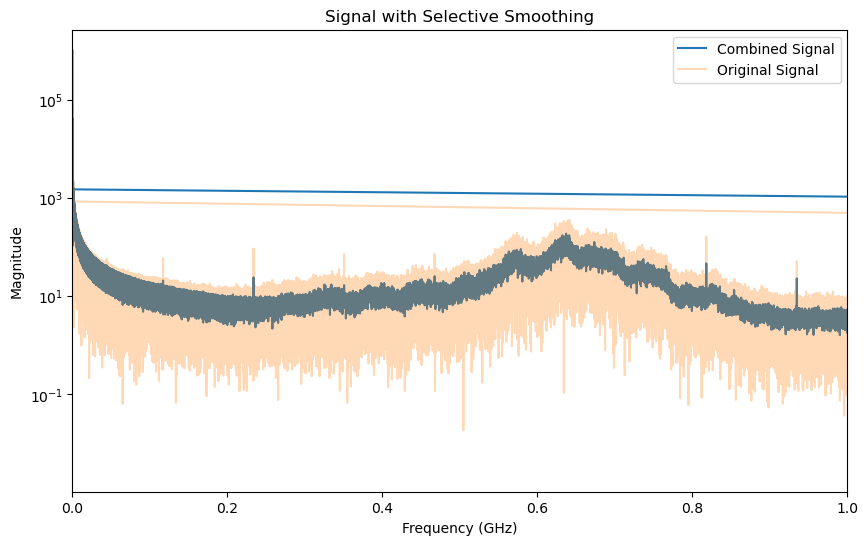

In [26]:

# Define your moving average function
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size), 'valid') / window_size

# Calculate the moving average of your signal
window_size = 10  # Adjust this as needed
smoothed_signal = moving_average(np.abs(emf_fft), window_size)

# Extend the smoothed_signal to the original length by padding
# This is needed to compare with the original signal
smoothed_signal_padded = np.pad(smoothed_signal, (window_size//2, window_size//2 - 1), mode='edge')

# Identify spikes - define your threshold
threshold = np.std(np.abs(emf_fft))  # Example threshold, adjust based on your signal

# Create a mask for spikes
spikes_mask = np.abs(np.abs(emf_fft) - smoothed_signal_padded) > threshold

# Combine the smoothed signal and the original spikes
combined_signal = np.where(spikes_mask, np.abs(emf_fft), smoothed_signal_padded)

# Plotting
plt.figure(figsize=(10, 6))
plt.semilogy(freq/1e9/0.8538, combined_signal, label='Combined Signal')
plt.semilogy(freq/1e9/0.8538, np.abs(emf_fft), label='Original Signal', alpha=0.3)
plt.xlim(0, 1)
plt.xlabel('Frequency (GHz)')
plt.ylabel('Magnitude')
plt.title('Signal with Selective Smoothing')
plt.legend()
plt.show()